**Import packages used throughout analysis**

In [1]:
# Basic imporrts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sqlalchemy import create_engine
import pickle

# Model preprocessing and processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.base import clone

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Performance evaluation
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score
import shap

# Display options
pd.options.display.max_columns = 200
%matplotlib inline

# Convenience for working with external .py files
%load_ext autoreload
%autoreload 2

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../src')
from custom_plots import *
from create_target import *
from remove_missing_data import *
from evaluate_model_performance import *

# Global constants
RANDOM_STATE = 2021

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Import "Regime Change" dataset**

Note that the SQL database being imported has been pre-cleaned with consequential feature engineering in the *cleaning_regime_changes_dataset.ipynb* notebook in this directory.

In [2]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/regime_changes.db')
with engine.begin() as connection:
    df_regimes = pd.read_sql('SELECT * FROM regime_changes', con=connection)

# Type casting
df_regimes.startdate = pd.to_datetime(df_regimes.startdate)
df_regimes.enddate = pd.to_datetime(df_regimes.enddate)

**Import "Protests" dataset**

Similar to above, the SQL database has already cleaned with some feature engineering taking place. Refer to *cleaning_protests_dataset.ipynb* in this directory for specifics. 

In [3]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/protests.db')
with engine.begin() as connection:
    df_protests = pd.read_sql('SELECT * FROM protests', con=connection)

# Type casting
df_protests.startdate = pd.to_datetime(df_protests.startdate)

**Import "Governments" dataset**

This SQL database has already undergone very notable, detail-oriented data cleaning in the *cleaning_governments_dataset.ipynb* notebook in this directory. Notably, it also serves the role of decreasing the number of features from 77 (in the original dataset) to 55 here. That number will again be substantially reduced in the data cleaning section below.

In [4]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/governments.db')
with engine.begin() as connection:
    df_govts = pd.read_sql('SELECT * FROM governments', con=connection)

# Set index to be used in SQL join
df_govts.index = df_govts.year_scode

# Drop now-duplicated feature
df_govts.drop('year_scode', axis=1, inplace=True)

**Join "Protests" and "Governments" datasets**

By joining these two datasets, a new dataframe is created with each row corresponding to one protest, containing original features about that protest as well as the characteristics of the government in place in that country during the selected year. The two datasets are joined on the index of *"year_of_protest"_"three-letter_country_code"*, otherwise known as *"year_scode"*.

In [5]:
# Join both dataframes
df = df_protests.join(df_govts, how='left', on='year_scode')

# Remove entries that don't have corresponding 'government' data
df.dropna(inplace=True)

##### Identify countries that are missing from "Regime Changes" dataset

In [6]:
# All countries in union of Protests and Governments
all_countries = df.scode.unique()

# All countries in Regimes
regime_countries = df_regimes.scode.unique()


# Loop over all_countries
missing = []
for country in all_countries:
    # Make note of any countries not in Regimes
    
    if country not in regime_countries:
        missing.append(country)


# Remove these countries from dataset
scodes_to_remove_ind = [x in missing for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

**Join with "Regime Changes" dataset**

Add the third and final dataset, which includes the "target" feature of the analysis. 

In [7]:
target = create_target(df, df_regimes)
df = pd.concat([df, target], axis=1)

### Basic cleaning

Start by running custom function that removes all features that don't have a minimum threshold of non-null values

In [8]:
# Remove entries with limited "government" data
df = remove_missing_data(df, 1000)

In [9]:
# Convert startdate to a float instead of datetime since datetime cannot be 
# handled by models but fractional years can
df['startdate'] = df.startdate.dt.year + \
                  df.startdate.dt.month/12 + \
                  df.startdate.dt.day/365

In [10]:
# Type casting
df['region'] = df.region.astype('category')
df['system'] = df.system.astype('category')
df['country'] = df.country.astype('category')
df['xconst'] = df['xconst'].astype('int')

##### Fill "placeholder" values in *xconst* with continuous numbers. See Model.ipynb for further details.

In [11]:
df.xconst.replace(-66.0, -1, inplace=True) # 'Interruption periods'
df.xconst.replace(-77.0, -2, inplace=True) # 'Interregnum periods'
df.xconst.replace(-88.0, 0, inplace=True) # 'Transition periods'

#### Define target
This allows the user to define the target in terms of the amount of time before which a regime transition will occur. For this analysis, it uses one year, but other values have also been explored with similar results.

In [12]:
DAYS_UNTIL_CHG = 365
target = pd.DataFrame(df['days_until_next_regime_chg'] < DAYS_UNTIL_CHG)
target = target.astype('int')
target.columns = ['target']

#### Drop unused columns

Refer to "model.ipynb" notebook for decision-making details. Specific descisions will not be discussed here as they are covered in depth in the previously mentioned file.

In [13]:
drop_cols = ['year_scode', 'scode_govt', 'country_govt', 'startdate',
             'days_until_next_regime_chg', 'scode', 'participants_category', 'participants',
             'next_regime_chg_date', 'index', 'duration_days', 'present', 'protestnumber']
df.drop(drop_cols, axis=1, inplace=True)


# Features with high collinearity
colinear_cols = ['liec', 'eiec', 'tenlong_strict', 'tenshort_strict', 'finittrm', 'govfrac', 'oppvote']
df.drop(colinear_cols, axis=1, inplace=True)

### Feature descriptions

Given the large number of features with abbreviated names, those that are used within the model are defined below.

Protest Details - as provided by *Protests* dataset:
- **country:** location of protest
- **region:** global region
- **protesterviolence:** (y/n) indicator of protester violence
- **participants_log:** number of individuals in attendance, log-transformed
- **duration_days_log:** duration of the protest, log-transformed
- **protestnumber_log:** protest number in the selected country in a given year, log-transformed

---

Categorizations of the reason for a protest (multiple options possible) - as provided by *Protests* dataset:
-  **labor wage dispute** 
-  **land farm issue** 
-  **police brutality** 
-  **political behavior/process** 
-  **price increases/tax policy** 
-  **removal of politician** 
-  **social restrictions** 

---

Government descriptors in the given country at the time protest - as provided by *Government Characterization* dataset. Strict, quantifiable definitions are provided in Data Manual.

- **system:** governmental system (Parliamentary, Assembly-elected president, Presidential, Unelected)
- **yrsoffc:** number of years the chief executive has been in office
- **termlimit:** (y/n) is there a term limit in place?
- **military:** (y/n) is the chief executive a military officer?
- **defmin:** (y/n) is defense minister a military officer?
- **execnat:** (y/n) is executive a nationalist?
- **execrel:** executive religion
- **totalseats:** total seats in the legislature
- **oppmajh:** (y/n) does one opposition party have an absolute majority in House?
- **legelec:** (y/n) is there a legislative election in the protest year?
- **exelec:** (y/n) is there an executive election in the protest year?
- **gq:** are there gender quotas in government (None, Voluntary, Reserved, Required)
- **gqi:** (y/n) is gender quota actually implemented
- **auton:** are there autonomous regions? (federalism)
- **numvote:** total vote share of governmental leadership party
- **maj:** margin of majority
- **herfgov:** Herfindahl index government (sum of squared seat shares of all parties in the government)
- **tensys_strict:** length of time the country has been autocratic or democratic
- **checks:** checks and balances
- **stabs_strict:** stability, as measured by the percent of veto players who *drop* from the government in a given year

---

Political regime authority characteristics - as provided by *Regime Changes* dataset. Strict, quantifiable definitions are provided in Data Manual.

- **xconst:** executive constraints / decision rules (Unlimited Authority through Executive Parity)

In [14]:
# Create standard train-test splits
x_train, x_test, y_train, y_test = train_test_split(df, target, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=0.3)

The random forest model shows substantial performance over the logistic regression model. Specifically, the F1 score increased by 0.12, and other metrics see similar improvements. Still, the performance isn't perfect, so the below model explores an increasingly complex model that is able to better capture the complexity of the data.

**XG Boost model**

- f1: 0.7951807228915663
- accuracy: 0.9617117117117117
- precision: 0.8571428571428571
- recall: 0.7415730337078652


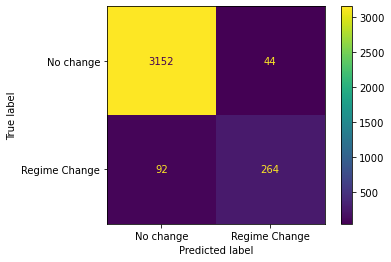

In [16]:
# # Instantiate model
# model_log = LogisticRegression(max_iter=5000)

# # Add one-hot encoding for categoricals
# ohe = OneHotEncoder(handle_unknown='ignore')

# # Add standard scaling
# scaler = StandardScaler()

# # Add resampling to address class imbalance
# smote = SMOTE(random_state=RANDOM_STATE)


# # Select object types for one-hot encoding and numeric types for scaling
# selector_object = make_column_selector(dtype_exclude='number')
# selector_numeric = make_column_selector(dtype_include='number')

# # Create transformer for the selectors/encoders/scalers
# transformer = make_column_transformer((ohe, selector_object),
#                                      (scaler, selector_numeric))


# # Create pipeline for transformer, resampling, and model
# pipe = Pipeline([('transformer', transformer),
#                  ('smote', smote), 
#                  ('model', model_log)])


# # Instantiate model
# model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
#                           random_state=RANDOM_STATE)

# # Create pipeline for transformer, resampling, and model
# pipe = Pipeline([('transformer', transformer),
#                  ('smote', smote), 
#                  ('model', model_xgb)])


# # Run grid search to optimizer hyperparameters
# grid_xgb = {
#     'model__learning_rate': [0.01, 0.1, 0.25],
#     'model__max_depth': [6, 8, 10, 12],
#     'model__subsample': [0.4, 0.7, 1],
#     'model__n_estimators': [100, 200, 300, 400]}

# # Fit model to training data
# # grid_search.fit(x_train, y_train)

# As described in this section's header, the fitted pipeline is 
# simply imported via Pickle from the MODEL notebook, where it was
# fitted on the same data.
with open('../data/processed/model_xgb.pickle', 'rb') as f:
    model_xgb = pickle.load(f)

# Fit pipeline
model_xgb.fit(x_train, y_train)
    
# Print metrics
prediction = model_xgb.predict(x_test)
print_scores(prediction, y_test)
labels = ['No change', 'Regime Change']

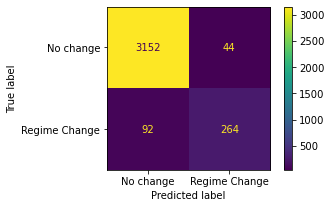

In [27]:
# Display confusion matrix
fig, ax = plt.subplots(1, 1)
fig.set_figheight(3)
fig.set_figwidth(5)
plot_confusion_matrix(model_xgb, x_test, y_test, display_labels=labels, ax=ax);
plt.savefig('../images/confusion_matrix_single.png', bbox_inches="tight")

**Show optimal model hyperparameters**

## Investigate Feature Importance

Here, we see that the five most significant features are:
1. **xconst**: presence of executive constraints, ranging from "Unlimited Authority" through "Executive Parity"
2. **protestnumber_log**: number of protests that already occurred in the year of the protest, log-transformed
3. **tensys_strict**: length of time the country has been autocratic or democratic
4. **totalseats**: total seats in the legislature
5. **yrsoffc**: number of years the chief executive has been in office

To bring some meaning to the SHAP summary plot, it is worth noting that:
1. Countries with low  executive constraint ("Unlimited Authority") are more strongly correlated with a protest overturning the regime.
2. Higher turnouts to protests are associated with regime transitions. However, the data is somewhat split: even very small protests can be associated with regime transition.
3. There is a less distinct divide in the relationship between the length of time a country has been autocratic vs. democratic than in other metrics. That said, the feature remains a strong predictor.
4. Regime transitions happen somewhat consistently across the size of governing bodies. 
5. Protests in countries with new executive leadership are less likely to lead to regime change than countries with a long-ruling leader.

In [ ]:
# SHAP summary plot for XGB
produce_shap_plot(x_train, y_train, x_test, y_test, clone(model_xgb), 
                  title='Final XG Boost Model: Feature Evaluation');

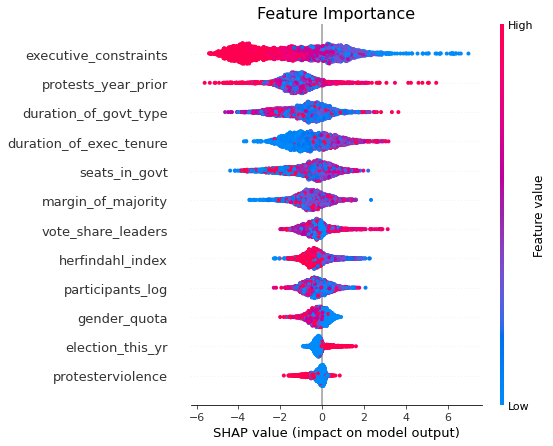

In [34]:
def produce_shap_plot(df_train, target_train, df_test, target_test, model_shap, title=None, savepath=None):   
    df_train, target_train, df_test = get_shap_df(df_train, target_train, df_test)
    model_shap = model_shap.steps[2][1]
    model_shap.fit(df_train, target_train)
    pred = model_shap.predict(df_test)
    
    # Produce shap values
    explainer = shap.TreeExplainer(model_shap)
    shap_values = explainer.shap_values(df_test)
    
    # Plot findings
    plt.figure()
    shap.summary_plot(shap_values, df_test, show=False, plot_size=(6.5, 7), max_display=12)
    
    # Add figure title if provided by user
    if title:
        plt.title(title, fontsize=16)
        
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    
    plt.show();





# renamer = {'xconst': 'executive_constraints',
#        'protestnumber_log': 'protests_year_prior',
#         'tensys_strict': 'duration_of_govt_type',
#         'yrsoffc': 'duration_of_exec_tenure',
#         'totalseats': 'seats_in_govt',
#         'maj': 'margin_of_majority',
#         'numvote': 'vote_share_leaders',
#         'participants': 'protest_participant_ct',
#         'herfgov': 'herfindahl_index',
#         'gq': 'gender_quota',
#         'legelec': 'election_this_yr'}
# x_train_renamed = x_train.rename(renamer, axis=1)
# x_test_renamed = x_test.rename(renamer, axis=1)
# model_xgb.fit(x_train_renamed, y_train)

produce_shap_plot(x_train_renamed, y_train, x_test_renamed, y_test, clone(model_xgb), 
                  title='Feature Importance',
                  savepath='../images/shap_summary_plot_renamed.png');


#shap.summary_plot(shap_values, df_test, show=False, plot_size=(16, 12))

In [ ]:
# SHAP bar plot for XGB model
x_tr_manual, y_tr_manual, x_te_manual = get_shap_df(x_train, y_train, x_test)
model = model_xgb.steps[2][1]

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(x_te_manual)

# SHAP bar plot for XGB model
plt.title('Feature Importance for XGB Model')
shap.plots.bar(shap_values, max_display=20)

## Part V. Conclusion

Overall, this analysis successfully completes its objective. It creates and tunes a model that helps predict whether a given protest will lead to a regime transition within one year. This incredibly valuable tool can be used by political scientists to better understand regime transitions, including my investigating the model further than was conducted in this analysis. In addition, the model and its findings can be used for proactive or preventative measures by either side of government. With a very strong performing model, it can be trusted to give an accurate estimate of changes to come. 

Going forward, this project allows for easy growth as more data is released. Each of the three primary datasets receive regular updates, and this new information can easily be incorporated in order to expand the temporal scope of the project and with more data comes to potential for stronger performance. 

### Next Steps
A powerful next step could be to investigate this data using time series analyses. Specifically, it would be valuable to understand how protest outcomes are affected by protests before it.